In [1]:
# detailed_response_analysis.ipynb
# Avery Krieger 07/27/2023

# this allows you to edit src code and run 
# (the alternative is to restart the kernel EVERY time you make a change to src...BAD)
%load_ext autoreload
%autoreload 2

from visanalysis.analysis import imaging_data, shared_analysis
from visanalysis.util import plot_tools

from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy import stats
from scipy.stats import wilcoxon
import pingouin as pg

import os
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd


/Users/averykrieger/envs/stim_analysis/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


# Loading from pickles

In [24]:
save_directory = "/Volumes/ABK2TBData/lab_repo/analysis/outputs/flash_w_opto_step/" #+ experiment_file_name + "/"
Path(save_directory).mkdir(exist_ok=True)

exp_control_rnai_advanced_by_roi = pd.read_pickle(save_directory + 'exp_control_rnai_advanced_by_roi_v2.pkl') # exp_control_rnai_advanced_by_roi_v2 exp_control_rnai_advanced_by_roi

## Subselect from the DF

In [25]:
# get the correct dataframe set up
which_df_placeholder = exp_control_rnai_advanced_by_roi
# copy, don't just set equal. Then combine the opto intensities 1 and 2
prox_win0_df = which_df_placeholder.loc[(which_df_placeholder['Layer'] == 'Proximal') & (which_df_placeholder['Window'] == 0)]

prox_win0_df

,ROI,Layer,PtT_Ratio,Pos_Integral,Neg_Integral,Integral_Ratio,Peak_Index,Trough_Index,Opto,Window,Type
567,0,Proximal,-1.861812,1.053534,0.387246,2.720583,5.0,11.0,0,0,experimental
571,0,Proximal,-3.453907,1.192383,0.303582,3.927719,5.0,12.0,1,0,experimental
575,0,Proximal,-3.896728,1.301823,0.817050,1.593321,5.0,12.0,2,0,experimental
579,1,Proximal,-6.476723,3.119474,-0.105854,29.469454,5.0,11.0,0,0,experimental
583,1,Proximal,-7.058708,3.411425,0.335826,10.158302,5.0,12.0,1,0,experimental
...,...,...,...,...,...,...,...,...,...,...,...
337,15,Proximal,-3.283047,1.499206,0.339724,4.413014,3.0,9.0,1,0,RNAi
341,15,Proximal,-3.909969,1.374525,0.635898,2.161549,3.0,9.0,2,0,RNAi
345,16,Proximal,-3.573351,1.669270,-0.173409,9.626201,3.0,11.0,0,0,RNAi
349,16,Proximal,-4.616918,1.563669,0.502896,3.109331,3.0,9.0,1,0,RNAi


# Violin Plots

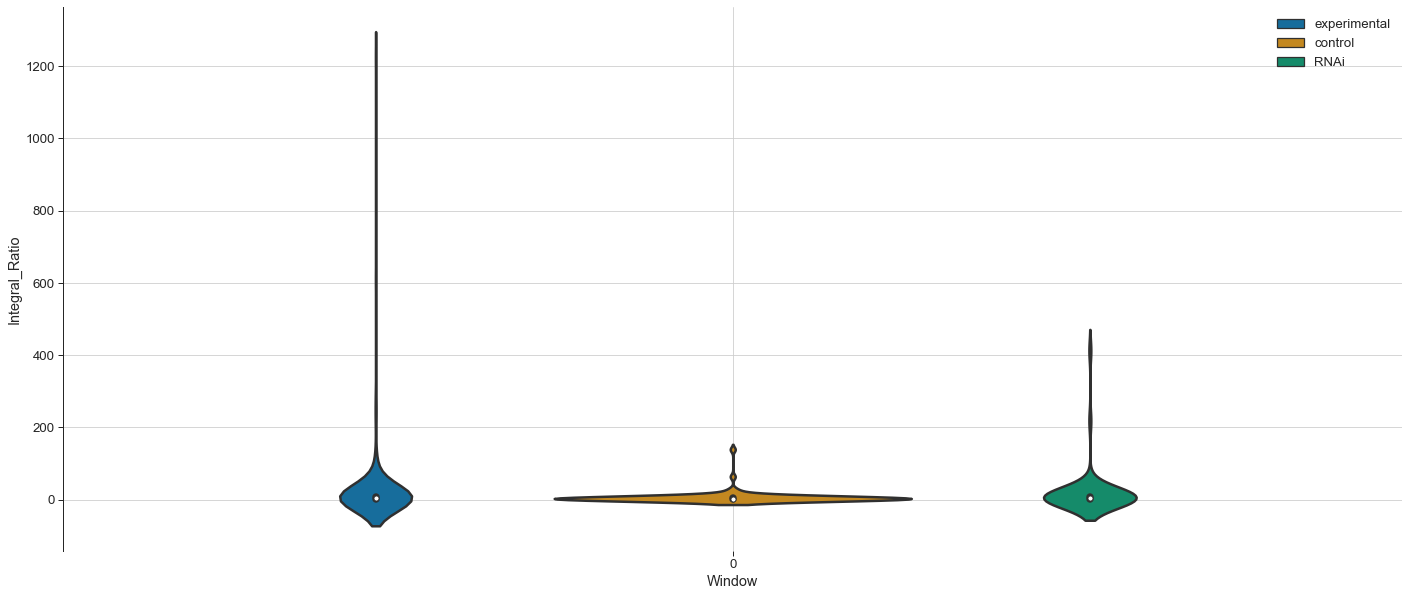

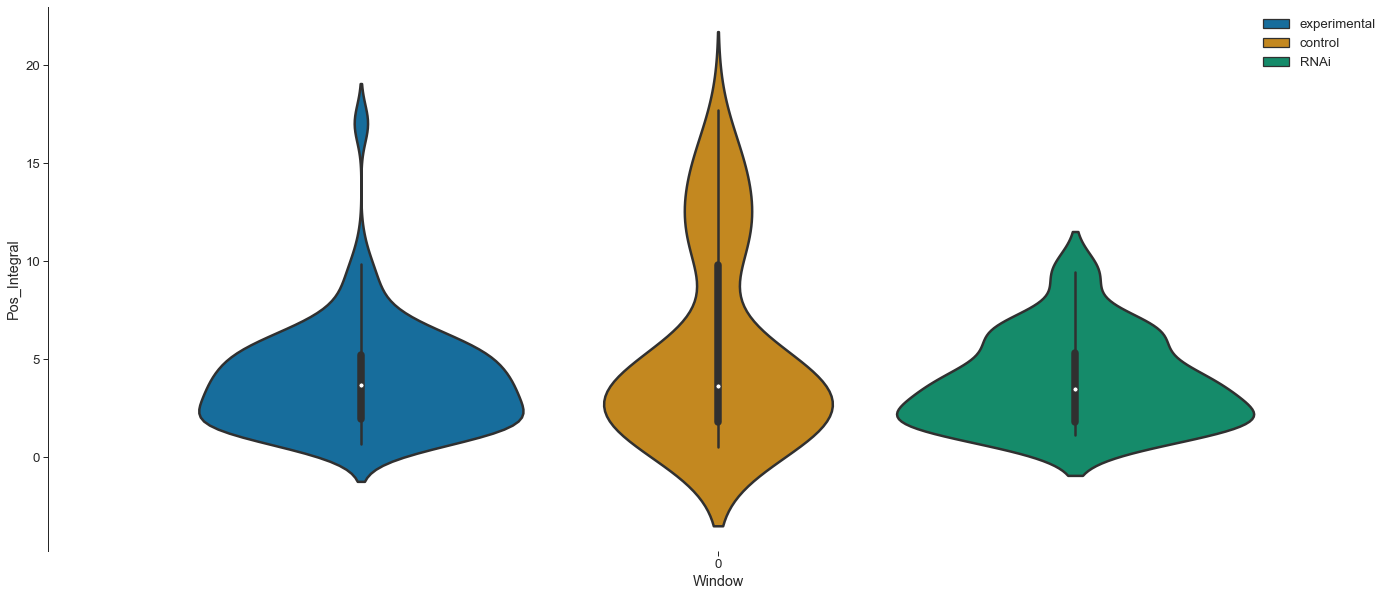

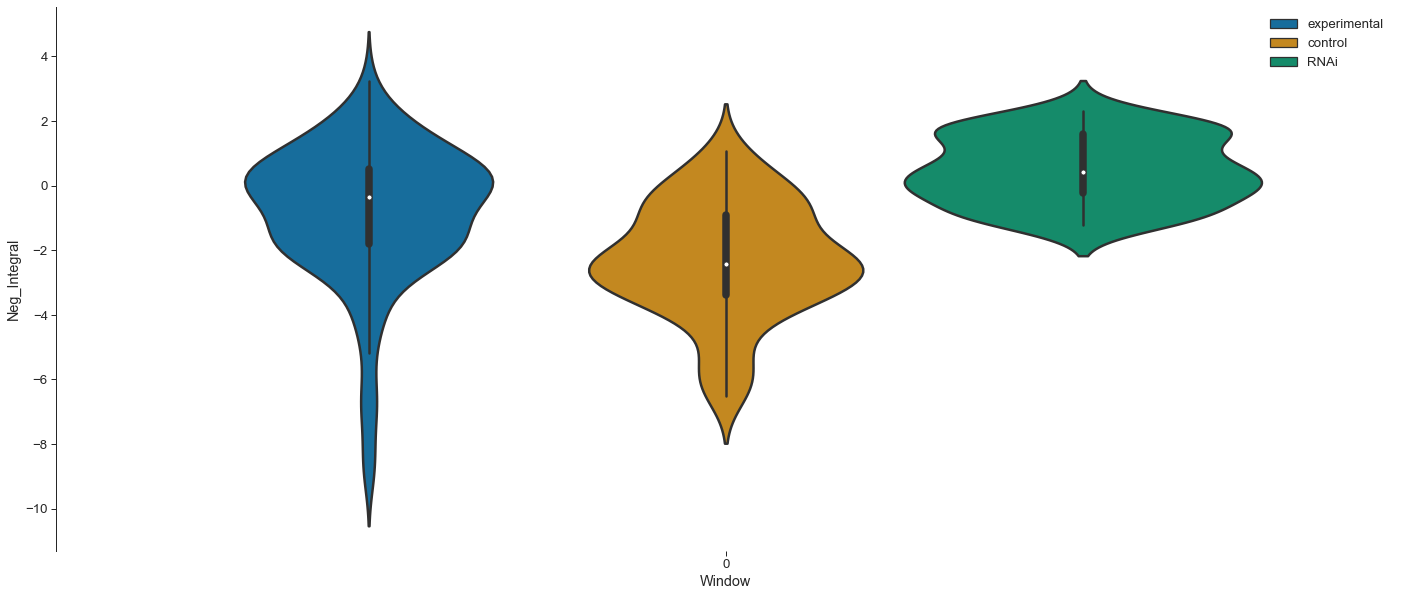

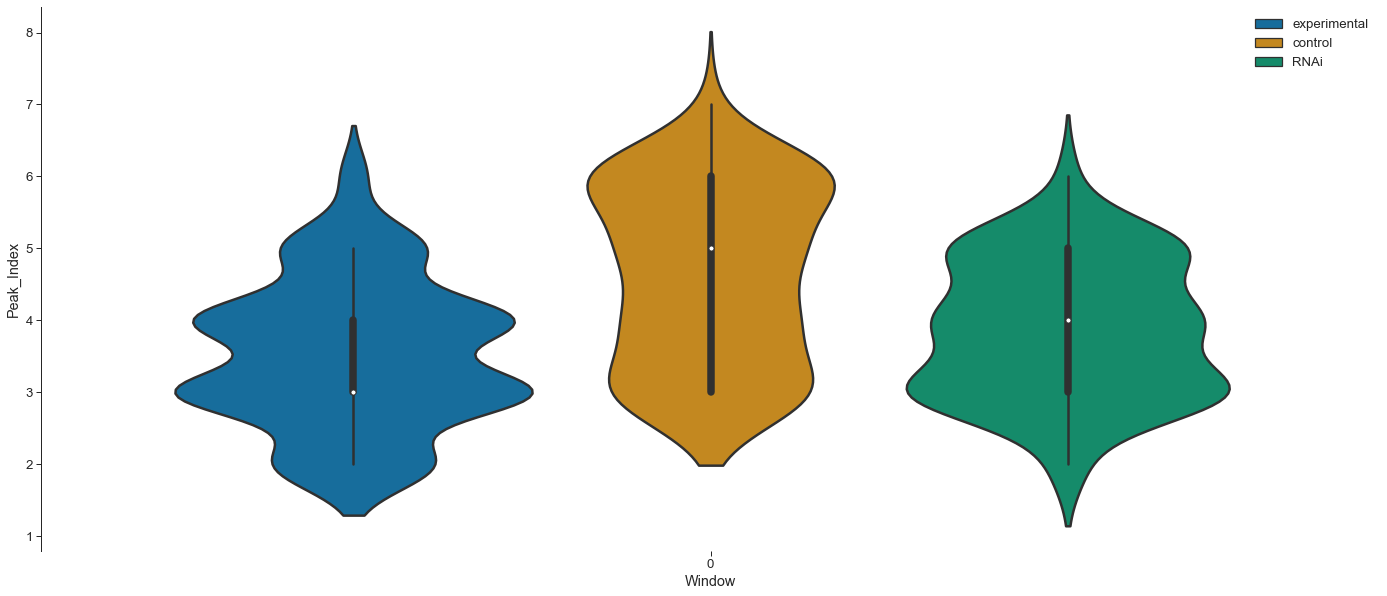

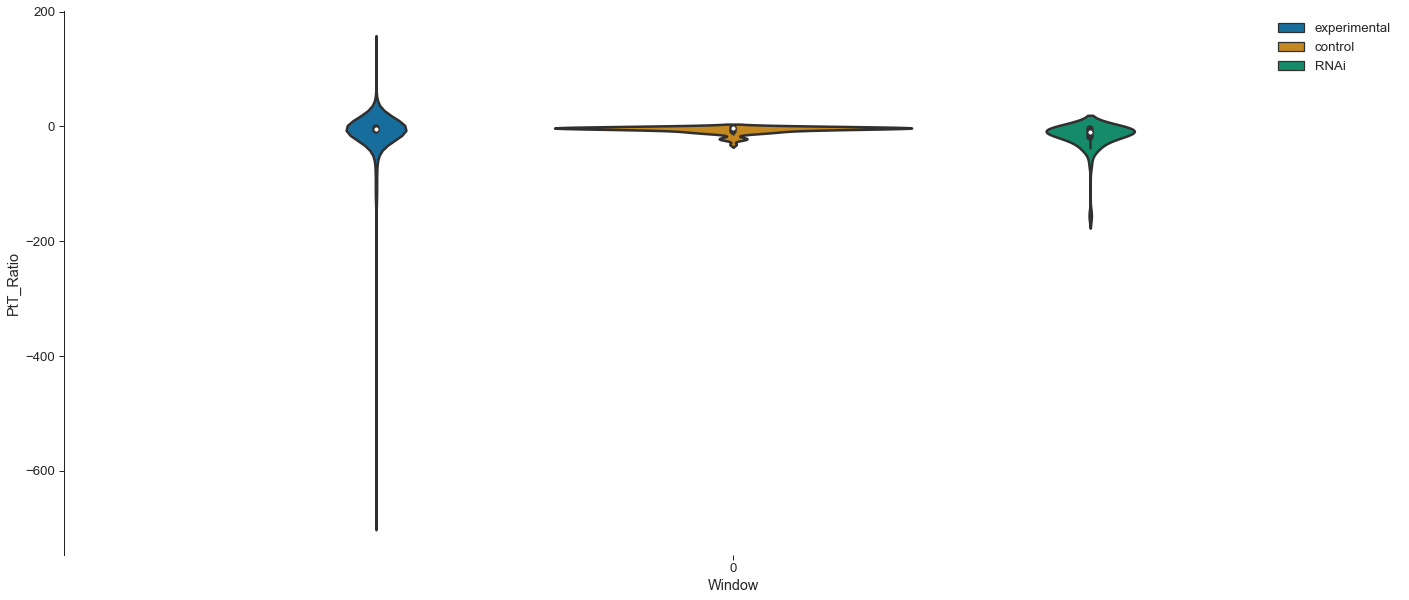

In [27]:
# Rapidly plot some metrics - 
save_fig = False
dv_set = ["PtT_Ratio", "Pos_Integral", "Neg_Integral", "Integral_Ratio", "Peak_Index", "Trough_Index"] 
win_set = [0, 1, 2]
type_set = ['experimental', 'control', 'RNAi']

dv = 'Integral_Ratio' # PtT Max 
sns.set_context("paper", font_scale=1.5)
comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
# Now, make the violinplot of the ROIs
sns.violinplot(
    #ax=comp_ax, data=exp_control_rnai_by_roi, x='Window', y=dv, hue='Type', # all opto collapsed
    ax=comp_ax, data=prox_win0_df, x='Window', y=dv, hue='Type', 
    palette='colorblind', orient='v', linewidth=2.5,
)
# # Cleaning up the plot
plt.grid()
comp_ax.legend(title='', frameon=False)
sns.despine(fig=comp_fig, top=True, right=True, bottom=True)


dv = 'Pos_Integral' 
sns.set_context("paper", font_scale=1.5)
comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
# Now, make the violinplot of the ROIs
sns.violinplot(
    #ax=comp_ax, data=exp_control_rnai_by_roi, x='Window', y=dv, hue='Type', # all opto collapsed
    ax=comp_ax, data=prox_win0_df, x='Window', y=dv, hue='Type', 
    palette='colorblind', orient='v', linewidth=2.5,
)
# # Cleaning up the plot
comp_ax.legend(title='', frameon=False)
sns.despine(fig=comp_fig, top=True, right=True, bottom=True)


dv = 'Neg_Integral' 
sns.set_context("paper", font_scale=1.5)
comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
# Now, make the violinplot of the ROIs
sns.violinplot(
    #ax=comp_ax, data=exp_control_rnai_by_roi, x='Window', y=dv, hue='Type', # all opto collapsed
    ax=comp_ax, data=prox_win0_df, x='Window', y=dv, hue='Type', 
    palette='colorblind', orient='v', linewidth=2.5,
)
# # Cleaning up the plot
comp_ax.legend(title='', frameon=False)
sns.despine(fig=comp_fig, top=True, right=True, bottom=True)


dv = 'Peak_Index' 
sns.set_context("paper", font_scale=1.5)
comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
# Now, make the violinplot of the ROIs
sns.violinplot(
    #ax=comp_ax, data=exp_control_rnai_by_roi, x='Window', y=dv, hue='Type', # all opto collapsed
    ax=comp_ax, data=prox_win0_df, x='Window', y=dv, hue='Type', 
    palette='colorblind', orient='v', linewidth=2.5,
)
# # Cleaning up the plot
comp_ax.legend(title='', frameon=False)
sns.despine(fig=comp_fig, top=True, right=True, bottom=True)


dv = 'PtT_Ratio' 
sns.set_context("paper", font_scale=1.5)
comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
# Now, make the violinplot of the ROIs
sns.violinplot(
    #ax=comp_ax, data=exp_control_rnai_by_roi, x='Window', y=dv, hue='Type', # all opto collapsed
    ax=comp_ax, data=prox_win0_df, x='Window', y=dv, hue='Type', 
    palette='colorblind', orient='v', linewidth=2.5,
)
# # Cleaning up the plot
comp_ax.legend(title='', frameon=False)
sns.despine(fig=comp_fig, top=True, right=True, bottom=True)

# if save_fig == True:
#     comp_fig.savefig(
#         save_directory
#         + "E.Summary"
#         + str(dv)
#         + "ViolinPlotAllWindows.Proximal.indFlies-"
#         + str(plot_flies)
#         + ".png",
#         dpi=300, bbox_inches='tight', transparent=False,
#     )
#     comp_fig.savefig(
#         save_directory
#         + "E.all_opto_Summary"
#         + str(dv)
#         + "ViolinPlotAllWindows.Proximal.indFlies-"
#         + str(plot_flies)
#         + ".svg",
#         dpi=300, bbox_inches='tight', transparent=False,
#     )

# Histograms

<AxesSubplot:xlabel='PtT_Ratio', ylabel='Count'>

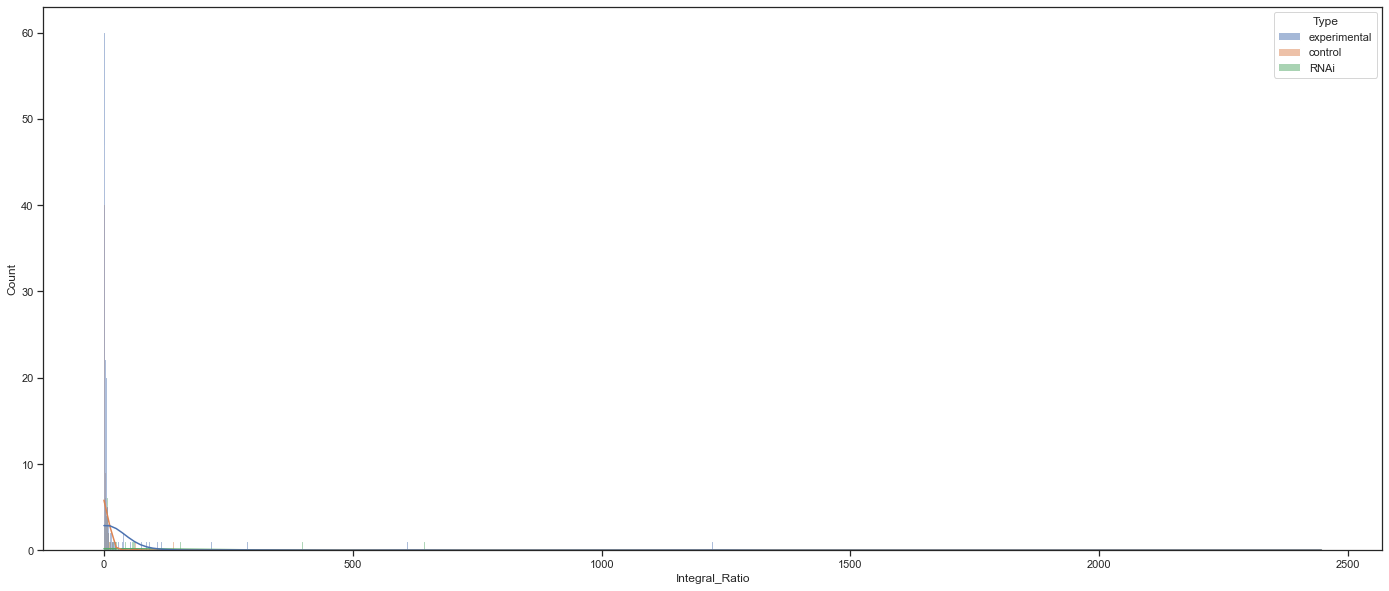

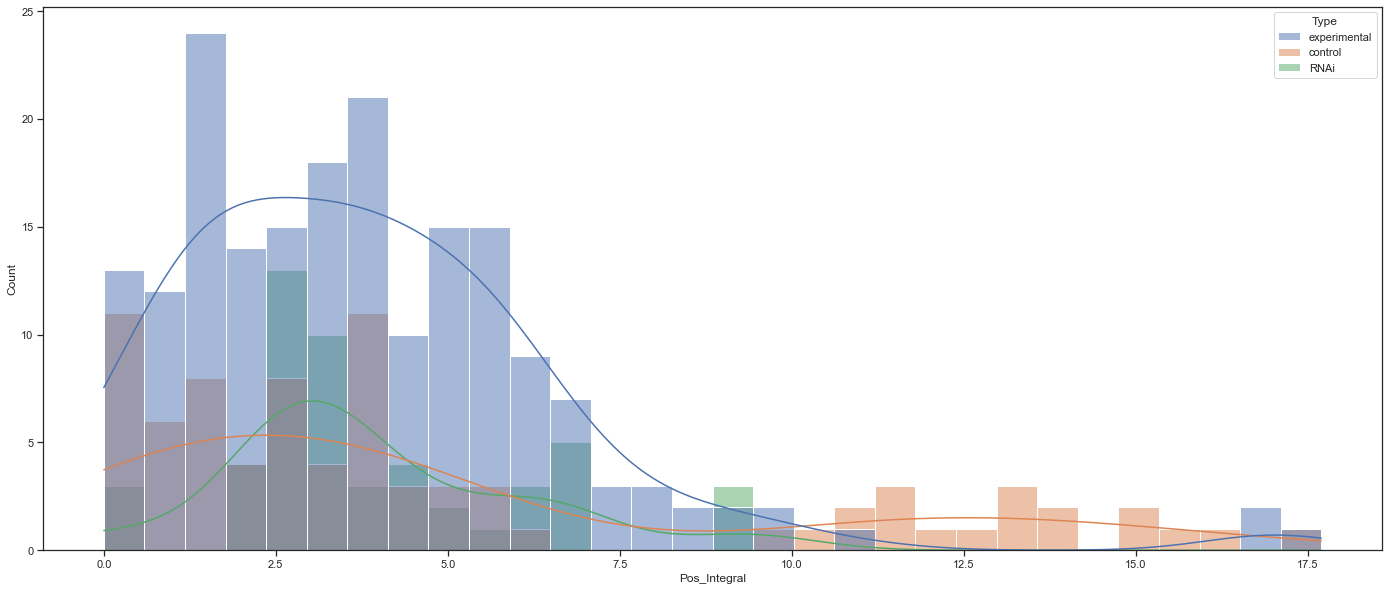

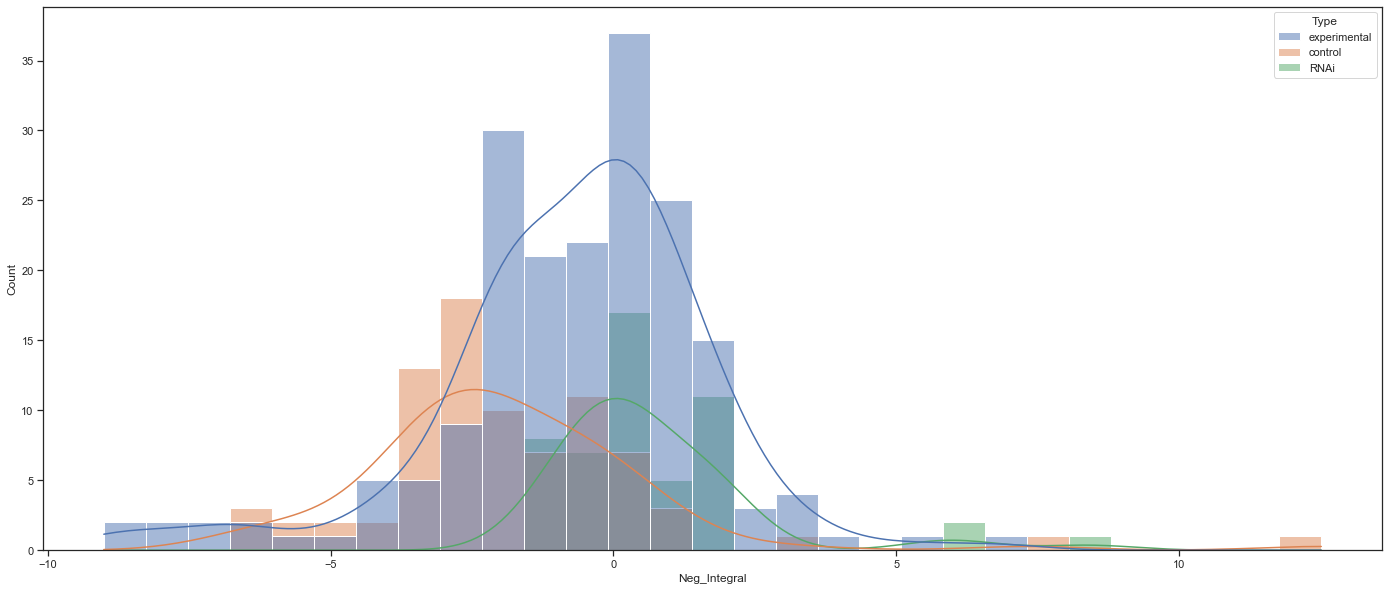

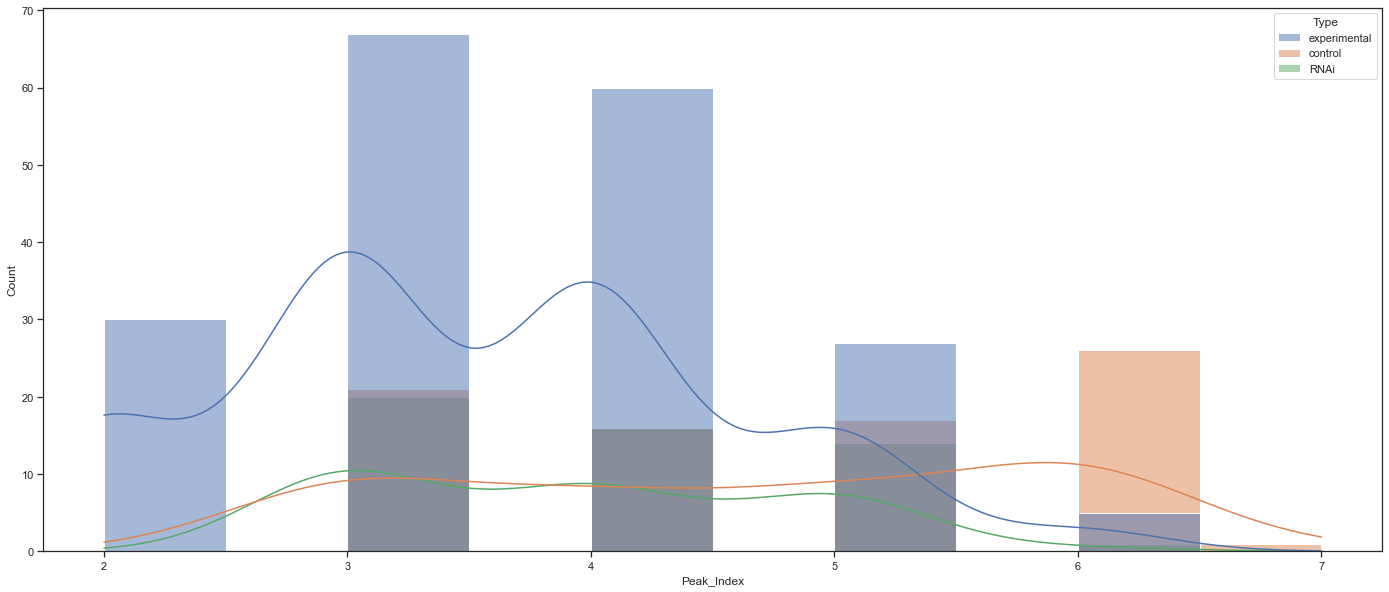

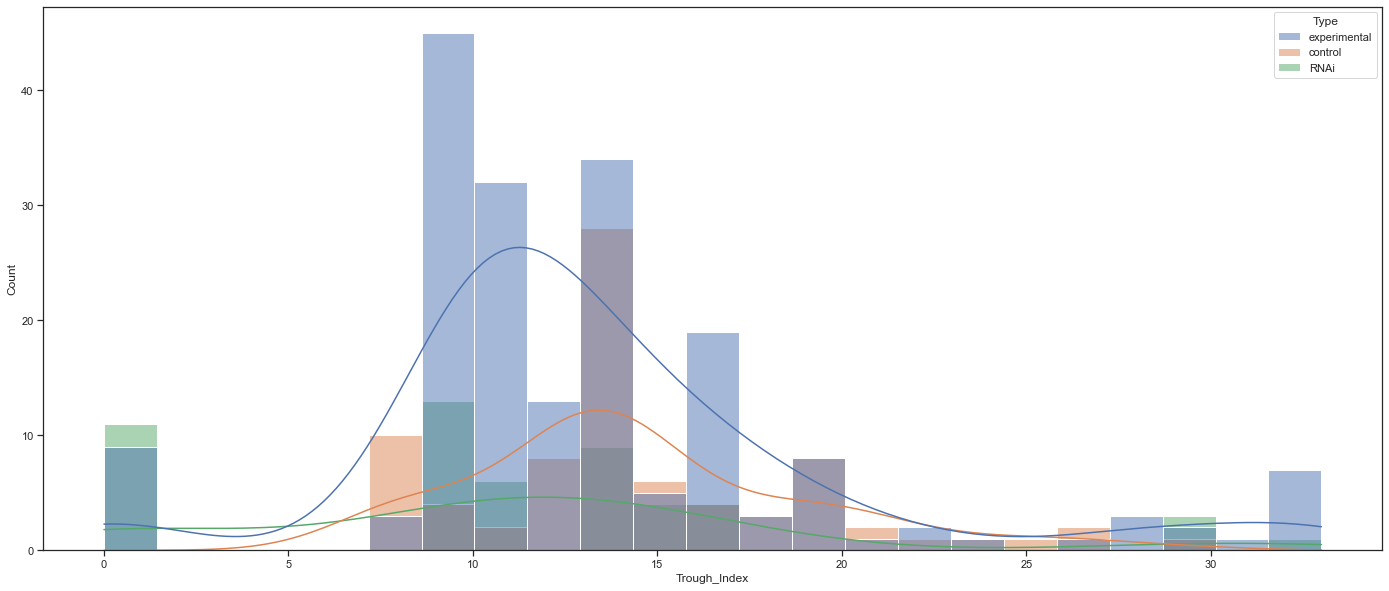

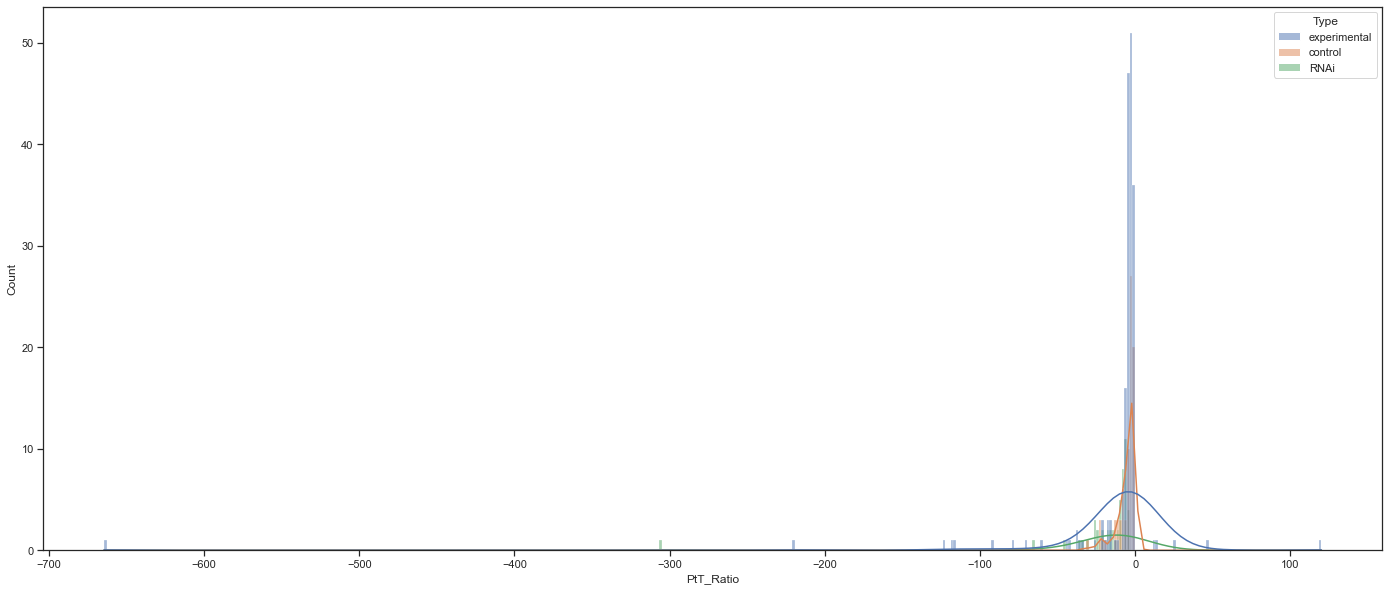

In [23]:
comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
sns.histplot(data=prox_winw0_df, x="Integral_Ratio", hue="Type", kde=True)

comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
sns.histplot(data=prox_winw0_df, x="Pos_Integral", hue="Type", bins=30, kde=True)

comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
sns.histplot(data=prox_winw0_df, x="Neg_Integral", hue="Type", kde=True)

comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
sns.histplot(data=prox_winw0_df, x="Peak_Index", hue="Type", kde=True)

comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
sns.histplot(data=prox_winw0_df, x="Trough_Index", hue="Type", kde=True)

comp_fig, comp_ax = plt.subplots(1, figsize=(8*len(win_set), 10))
sns.histplot(data=prox_winw0_df, x="PtT_Ratio", hue="Type", kde=True)

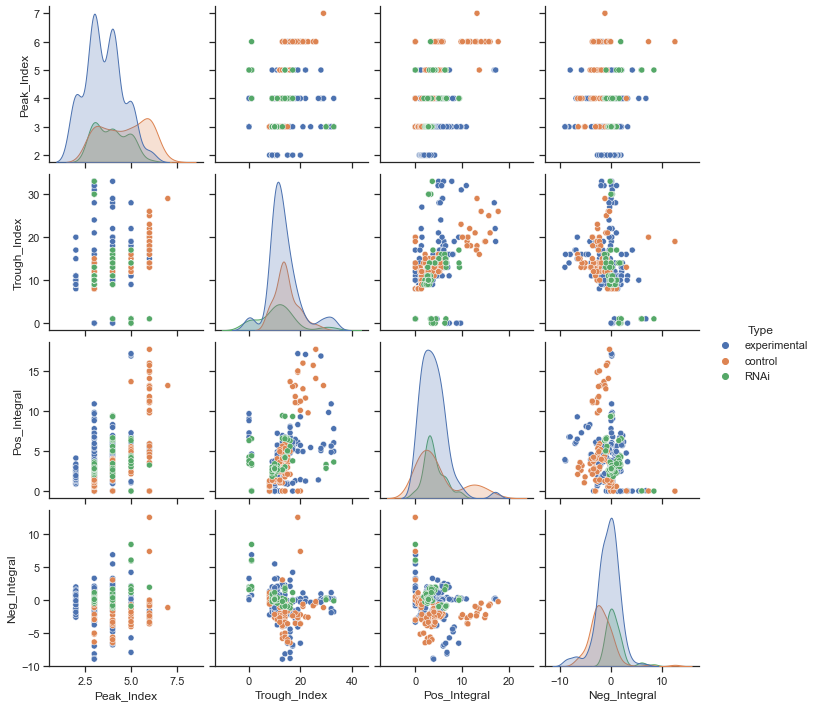

In [21]:
sns.set_theme(style="ticks")

sns.pairplot(
    prox_winw0_df, hue="Type", 
    x_vars=["Peak_Index", "Trough_Index", "Pos_Integral", "Neg_Integral"],
    y_vars=["Peak_Index", "Trough_Index", "Pos_Integral", "Neg_Integral"],
    )